In [1]:
from __future__ import division, print_function, unicode_literals, absolute_import
import numpy as np
import brainstorm as bs
import h5py
import pymongo
import seaborn as sns
import gridfs
import matplotlib.pyplot as plt
from matplotlib import cm
from itertools import product
import itertools
from IPython.core.debugger import Tracer
import subprocess
%matplotlib inline

In [2]:
with h5py.File('data50K.h5', 'r') as f:
    mins = f['training/default'].attrs['mins']
    maxs = f['training/default'].attrs['maxs']
    tstd = f['training/targets'].attrs['std']
    val_data = f['validation/default'][:]
    val_targets = f['validation/targets'][:]

## Get the network

In [3]:
net = bs.Network.from_hdf5('best_net.h5')

In [5]:
def generate_in_out(function, n=2, inp_values=(0, 1.), inp_idxs=(0, 1), outp_values=(0, 1.)):
    """
    Generate list of desired inputs and outputs.
    Parameters
    ----------
    function:
        the binary logical function to use
    n:
        number of points per input combination (should be even)
    inp_values: 
        values passed to the input pins that represent True and False
    outp_values: 
        values expected from the output pin that represent True and False
    inp_idxs: 
        indices of the input pins
    """
    values = np.linspace(inp_values[0], inp_values[1], n)
    truthy_values = np.zeros(n)
    truthy_values[n//2:] = 1.0
    inputs = list(product(values, values))
    outputs = [outp_values[function(a, b)] for a, b in product(truthy_values, truthy_values)]
    return inputs, outputs

def generate_random_inputs(inputs, outputs, inp_idxs=(0, 1)):
    """Generate inputs and outputs with a random configuration"""
    x = np.zeros((1, len(inputs), 8))
    x[0, :, :] = np.random.rand(1, 8)
    t = np.zeros((1, len(inputs), 1))
    for i, ((in1, in2), o) in enumerate(zip(inputs, outputs)):
        x[0, i, inp_idxs[0]] = in1
        x[0, i, inp_idxs[1]] = in2
        t[0, i, 0] = o 
    return x, t

In [6]:
def find_cfg(net, x, t, epochs, idxs, lr, verbosity=10):
    """Do SGD on the inputs while ignoring the given indices"""
    losses = np.zeros(epochs)
    for i in range(epochs):
        net.provide_external_data(dict(default=x, targets=t))
        net.forward_pass()
        #print(net.get_loss_values())
        losses[i] = net.get_loss_values()['total_loss']
        if verbosity and (i+1) % (epochs/verbosity) == 0:
            print(net.get_loss_values()['total_loss'])
            
        net.backward_pass()
        #Tracer()() # DEBUGGING
        d = net.get('Input.output_deltas.default')
        #print('sum: {:0.3f}'.format(d.sum()))
        d = d.sum(axis=1)
        d[0, idxs] = 0
        x -= lr * d[:, None, :]
        # clip values
        x[:] = np.clip(x, 0., 1.)
    return x, losses

In [7]:
def search(net, func, inp_idxs, inp_values, outp_values, n=2, 
           nr_starting_points=300, init_epochs=100, init_lr=.1,
           ref_epochs=10000, ref_lr=0.01):
    inputs, outputs = generate_in_out(func, n, inp_values, inp_idxs, outp_values)
    
    best_x = None
    best_loss = float('inf')
    print("Trying {} starting points ...".format(nr_starting_points))
    for i in range(nr_starting_points):
        x, t = generate_random_inputs(inputs, outputs, inp_idxs=inp_idxs)
        x, losses = find_cfg(net, x, t, init_epochs, inp_idxs, lr=init_lr, verbosity=0)
        
        loss = losses[-1]
        #print(loss)
        if loss < best_loss:
            best_x = x
            best_loss = loss
            print("  New best result from iteration {}: {}".format(i, best_loss))
    
    
    print('Refining for {} epochs...'.format(ref_epochs))
    x, losses = find_cfg(net, best_x, t, ref_epochs, inp_idxs, lr=ref_lr, verbosity=5)
    
    return x, t, losses

In [8]:
pin_names = np.array(['$V_{IN1}$', '$V_5$', '$V_4$', 
                      '$V_1$', '',   '$V_6$',   
                      '$V_{IN2}$', '$V_2$', '$V_3$']).reshape(3, 3)

def generate_bigger(func, n, x, inp_values, inp_idxs, outp_values):
    inps, outps = generate_in_out(func, n, inp_values, inp_idxs, outp_values)
    inps = np.array(inps)
    outps = np.array(outps)
    xs = np.zeros((1, len(inps), 8))
    xs[0, :, :] = x[0, 0, :]
    xs[0, :, inp_idxs] = np.array(inps).T
    return xs, outps[None, :, None]

def visualize_config(net, x, t, n, sim=None, ylabel=None):
    net.provide_external_data(dict(default=x, targets=t))
    net.forward_pass()
    out = net.buffer.Output.outputs.predictions.flatten()
    config_vis = np.array([
        [1, 7, 6],
        [3, 0, 8],
        [2, 4, 5]]).flatten()

    m = np.zeros(len(config_vis))
    x_ = np.hstack(([0], x[0, 0].flatten()))
    x_[1] = np.min(x[0, :, 0])
    x_[2] = np.max(x[0, :, 0])
    m[:] = x_[config_vis]
    ncols = 3 + (sim is not None)
    fig, axes = plt.subplots(ncols=ncols, figsize=(4*ncols, 4))
    vmin, vmax = sorted([np.min(t) * 1.1, np.max(t) * 1.1])
    print(vmin, vmax)
    print(t.shape)
    c = axes[0].matshow(np.abs(t.reshape(n, n)), cmap=cm.viridis)
    axes[0].set_title('Targets')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    c = axes[1].matshow(np.abs(out.reshape(n, n)), cmap=cm.viridis)#, vmin=vmin, vmax=vmax)
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_title('Neural Network Model')

    vrange = max(abs(m.min()), abs(m.max()))
    
    if sim is not None:
        c = axes[2].matshow(np.abs(sim.reshape(n, n)), cmap=cm.viridis)# ,vmin=vmin, vmax=vmax)
        axes[2].set_xticks([])
        axes[2].set_yticks([])
        axes[2].set_title('MECOBO')
        cfg_ax = axes[3]
    else:
        cfg_ax = axes[2]

    #c = cfg_ax.matshow(m.reshape(3, 3), vmin=0, vmax=1, cmap=cm.viridis)
    mask = (config_vis == 0).reshape((3, 3))
    c = sns.heatmap(m.reshape(3, 3), vmin=0.0, vmax=1.0, cmap='viridis', mask=mask, square=True, xticklabels=False, yticklabels=False, ax=cfg_ax)
    for (l, k), name in zip(itertools.product(range(3), repeat=2), 
                            pin_names.flatten()):
        cfg_ax.text(k+0.5, l+0.5, name, style='italic', ha="center", va="center", fontsize=12, 
                     color='k' if m.reshape(3, 3).T[:, ::-1][k,l] > 0.6 else 'w')
    cfg_ax.set_title('Configuration')
    cfg_ax.set_xticks([])
    cfg_ax.set_yticks([])
    #_ = fig.colorbar(c)
    if ylabel is not None:
        axes[0].set_ylabel(ylabel, fontweight='bold', fontsize=16)
    return fig

# Search for configurations

In [9]:
logical_functions = {
    'and': np.logical_and,
    'or': np.logical_or,
    'xor': np.logical_xor,
    'nand': lambda a, b: not np.logical_and(a,b),
    'nor': lambda a, b: not np.logical_or(a,b),
    'xnor': lambda a, b: not np.logical_xor(a,b)
}

In [10]:
n=4
N = 16
inp_idxs=(0, 1)
inp_values=(0., 1.0)
outp_values=(0, 1)

## AND Gate

Trying 100 starting points ...
  New best result from iteration 0: 0.334401488304
  New best result from iteration 4: 0.132108062506
  New best result from iteration 13: 0.117859385908
  New best result from iteration 18: 0.106274008751
  New best result from iteration 28: 0.0283543504775
Refining for 500 epochs...
0.00869100354612
0.00831856019795
0.00808309670538
0.00793991610408
0.00785348564386
0.0 1.1
(1, 256, 1)


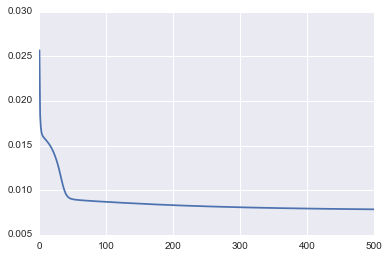

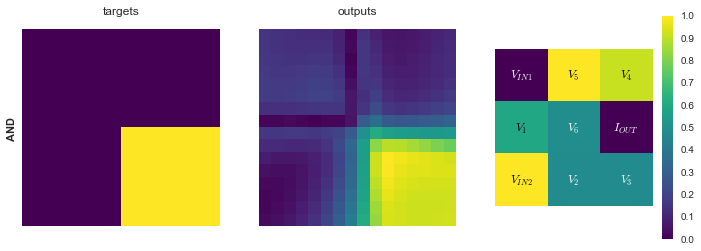

In [15]:
func=logical_functions['and']
x, t, losses = search(net, func, inp_idxs, inp_values, outp_values, n,
                      nr_starting_points=100,
                      init_lr=0.1,
                      init_epochs=10,
                      ref_lr=.03,
                      ref_epochs=500)
plt.plot(losses)


X, T = generate_bigger(func, N, x, inp_values, inp_idxs, outp_values)

#sim = run_sim(X[0], mins, maxs, tstd)

fig = visualize_config(net, X, T, N, sim=None, ylabel='AND')

In [16]:
fig.savefig('figures/AND.pdf', bbox_inches='tight', pad_inches=0)
np.savez_compressed('figures/AND.npz', X=X, T=T)

Trying 1000 starting points ...
  New best result from iteration 0: 0.133951485157
  New best result from iteration 14: 0.0541671402752
  New best result from iteration 56: 0.034204300493
  New best result from iteration 189: 0.0270346775651
  New best result from iteration 560: 0.00768624152988
Refining for 5000 epochs...
0.00272763194516
0.00272762170061
0.00272762076929
0.00272762076929
0.00272762076929
0.0 1.1
(1, 256, 1)


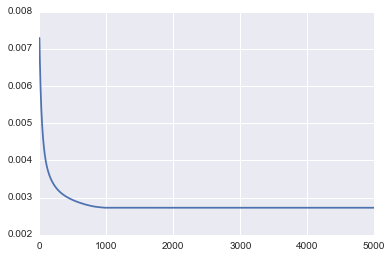

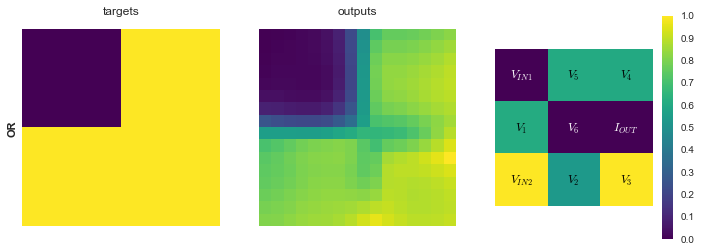

In [17]:
func=logical_functions['or']
x, t, losses = search(net, func, inp_idxs, inp_values, outp_values, n,
                      nr_starting_points=1000,
                      init_lr=0.1,
                      init_epochs=10,
                      ref_lr=.03,
                      ref_epochs=5000)
plt.plot(losses)


X, T = generate_bigger(func, N, x, inp_values, inp_idxs, outp_values)
#sim = run_sim(X[0], mins, maxs, tstd)
fig = visualize_config(net, X, T, N, sim=None, ylabel='OR')

In [18]:
fig.savefig('figures/OR.pdf', bbox_inches='tight', pad_inches=0)
np.savez_compressed('figures/OR.npz', X=X, T=T)

Trying 1000 starting points ...
  New best result from iteration 0: 0.140373215079
  New best result from iteration 2: 0.113669551909
  New best result from iteration 48: 0.104651376605
  New best result from iteration 124: 0.104392625391
  New best result from iteration 227: 0.0985977426171
  New best result from iteration 234: 0.092759013176
  New best result from iteration 327: 0.090315580368
  New best result from iteration 400: 0.0876657441258
  New best result from iteration 634: 0.0851512551308
Refining for 5000 epochs...
0.0767624229193
0.0767624080181
0.0767623782158
0.076762393117
0.0767624080181
0.0 1.1
(1, 256, 1)


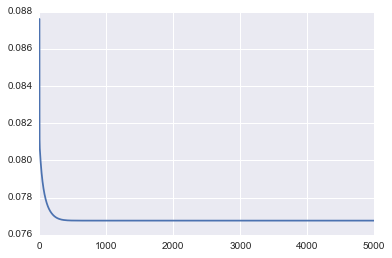

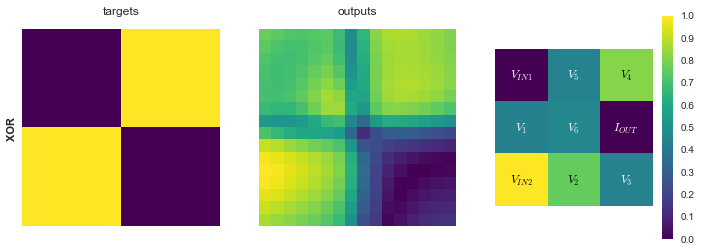

In [26]:
func=logical_functions['xor']
x, t, losses = search(net, func, inp_idxs, inp_values, (0., -1.), n,
                      nr_starting_points=1000,
                      init_lr=0.1,
                      init_epochs=10,
                      ref_lr=.03,
                      ref_epochs=5000)
plt.plot(losses)


X, T = generate_bigger(func, N, x, inp_values, inp_idxs, outp_values)
#sim = run_sim(X[0], mins, maxs, tstd)
fig = visualize_config(net, X, T, N, sim=None, ylabel='XOR')

In [27]:
fig.savefig('figures/XOR.pdf', bbox_inches='tight', pad_inches=0)
np.savez_compressed('figures/XOR.npz', X=X, T=T)

xor_data = np.load('figures/XOR.npz')['arr_0'].reshape(1)[0]
T = xor_data['T']
X = xor_data['X']
sim = xor_data['sim']


Trying 1000 starting points ...
  New best result from iteration 0: 0.17359764874
  New best result from iteration 1: 0.065651871264
  New best result from iteration 2: 0.0292991828173
  New best result from iteration 59: 0.0289102382958
  New best result from iteration 90: 0.0210599713027
  New best result from iteration 548: 0.0194208659232
Refining for 5000 epochs...
0.0130075542256
0.0130075551569
0.0130075588822
0.0130075532943
0.0130075514317
0.0 1.1
(1, 256, 1)


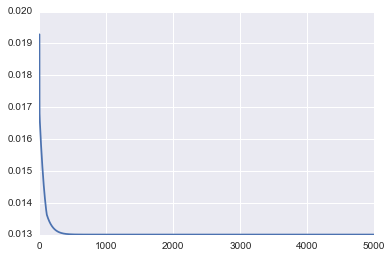

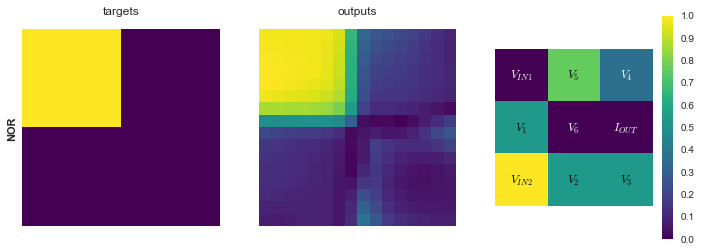

In [22]:
func=logical_functions['nor']
x, t, losses = search(net, func, inp_idxs, inp_values, (0.0, -1.0), 8,
                      nr_starting_points=1000,
                      init_lr=0.1,
                      init_epochs=10,
                      ref_lr=.03,
                      ref_epochs=5000)
plt.plot(losses)


X, T = generate_bigger(func, N, x, inp_values, inp_idxs, (0.0, 1.0))
fig = visualize_config(net, X, T, N, ylabel='NOR')

In [23]:
fig.savefig('figures/NOR.pdf', bbox_inches='tight', pad_inches=0)
np.savez_compressed('figures/NOR.npz', X=X, T=T)

Trying 1000 starting points ...
  New best result from iteration 0: 0.018328346312
  New best result from iteration 3: 0.0171187259257
  New best result from iteration 26: 0.0170495975763
  New best result from iteration 27: 0.0151706291363
  New best result from iteration 158: 0.0146691482514
  New best result from iteration 276: 0.0144470380619
  New best result from iteration 660: 0.0139349941164
  New best result from iteration 944: 0.0117254815996
Refining for 2000 epochs...
0.0106715010479
0.0106240138412
0.0106203239411
0.0106200212613
0.0106199868023
0.0 1.1
(1, 256, 1)


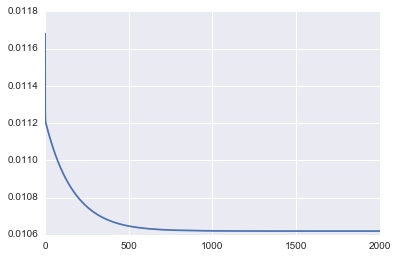

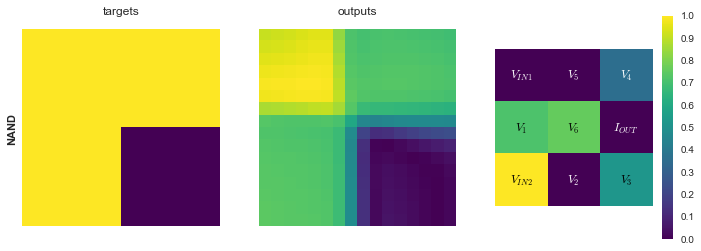

In [24]:
func=logical_functions['nand']
x, t, losses = search(net, func, inp_idxs, (0, 1), (0.0, -1), 8,
                      nr_starting_points=1000,
                      init_lr=0.1,
                      init_epochs=10,
                      ref_lr=.03,
                      ref_epochs=2000)
plt.plot(losses)


X, T = generate_bigger(func, N, x, inp_values, inp_idxs, outp_values)
fig = visualize_config(net, X, T, N, ylabel='NAND')

In [25]:
fig.savefig('figures/NAND.pdf', bbox_inches='tight', pad_inches=0)
np.savez_compressed('figures/NAND.npz', X=X, T=T)

# Run on live Board

In [28]:
import sys
from time import *
import itertools
import matplotlib.pyplot as plt
sys.path.append('../Thrift interface/gen-py/NascenseAPI_v01e/')
import emEvolvableMotherboard
import random
from ttypes import *

from bitstring import *
from thrift import Thrift
from thrift.transport import TSocket
from thrift.transport import TTransport
from thrift.protocol import TBinaryProtocol
import random as rnd

In [75]:
def run_on_board(X):
    transport = TSocket.TSocket('129.241.111.249', 9090)
    transport = TTransport.TBufferedTransport(transport)

    prot = TBinaryProtocol.TBinaryProtocol(transport)
    cli = emEvolvableMotherboard.Client(prot);
    transport.open();
    recordings = list(range(8, 9))
    configPins = list(range(0, 8))
    all_results = []
    
    try:
        for inputs in X[0]:
            cli.reset()
            cli.clearSequences()
            inputs = (inputs * (maxs - mins) + mins).astype(np.int)
            #print(inputs, end='')
            for i, p in zip(configPins, inputs):
                it = emSequenceItem()
                it.pin = [i]
                it.startTime = 1
                it.endTime = 49
                it.amplitude = p
                it.operationType = emSequenceOperationType().CONSTANT
                cli.appendSequenceAction(it)

            for r in recordings:
                it = emSequenceItem()
                it.pin = [r]
                it.startTime = 0
                it.endTime = 50
                it.frequency = 100000
                it.operationType = emSequenceOperationType().RECORD   
                cli.appendSequenceAction(it)

            cli.runSequences()
            cli.joinSequences()

            for rr in recordings:
                res = []
                for i in cli.getRecording(rr).Samples:
                    res.append(i * (5.0/4096.0));

            all_results.append((inputs, res))
            #print("\t => ", np.mean(res[:-1]))
            print(" {:0.2f}".format(np.mean(res[:-1])), end=' ')
        print('DONE')
        return np.array([np.mean(x[:-1]) for i, x in all_results]), all_results
    
    finally:
        transport.close()
    
    

 -0.18  -0.18  -0.18  -0.18  -0.18  -0.18  -0.17  -0.09  0.06  0.11  0.11  0.11  0.11  0.11  0.11  0.11  -0.18  -0.18  -0.18  -0.18  -0.18  -0.18  -0.18  -0.09  0.06  0.11  0.11  0.11  0.11  0.11  0.11  0.11  -0.18  -0.18  -0.18  -0.18  -0.18  -0.18  -0.18  -0.09  0.06  0.11  0.11  0.11  0.11  0.11  0.11  0.11  -0.18  -0.18  -0.18  -0.18  -0.18  -0.18  -0.18  -0.09  0.06  0.11  0.11  0.11  0.11  0.11  0.11  0.11  -0.18  -0.18  -0.18  -0.18  -0.18  -0.18  -0.18  -0.09  0.06  0.11  0.11  0.11  0.11  0.11  0.11  0.11  -0.18  -0.18  -0.18  -0.18  -0.18  -0.18  -0.18  -0.09  0.06  0.11  0.11  0.11  0.11  0.11  0.11  0.11  -0.18  -0.18  -0.18  -0.18  -0.18  -0.18  -0.17  -0.09  0.06  0.11  0.11  0.11  0.11  0.11  0.11  0.11  -0.07  -0.07  -0.07  -0.07  -0.07  -0.07  -0.07  -0.02  0.10  0.16  0.15  0.16  0.15  0.15  0.15  0.15  0.07  0.07  0.07  0.07  0.07  0.07  0.07  0.10  0.22  0.30  0.30  0.30  0.30  0.30  0.30  0.30  0.11  0.11  0.11  0.11  0.11  0.11  0.11  0.14  0.29  0.62  0.65  0.65 

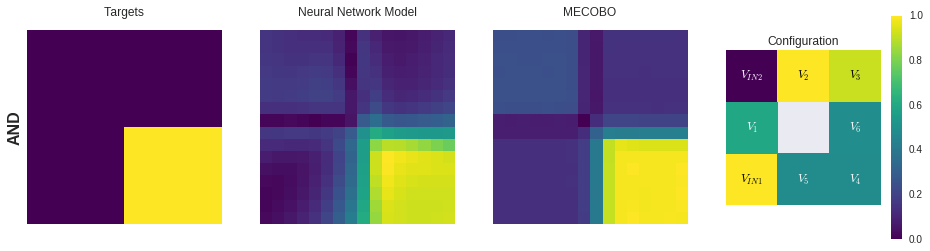

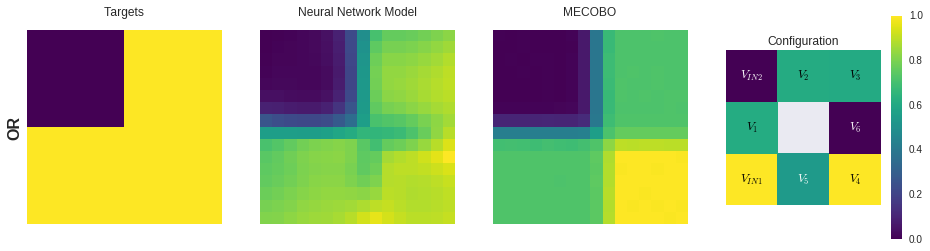

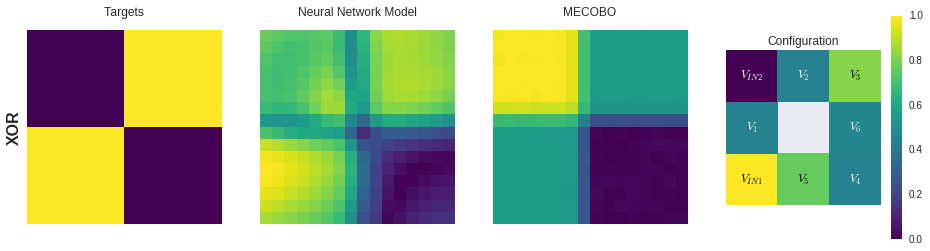

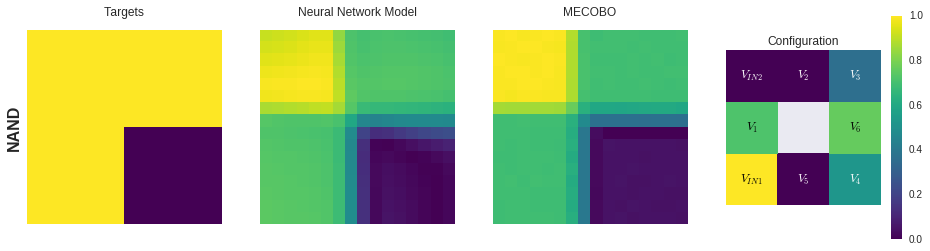

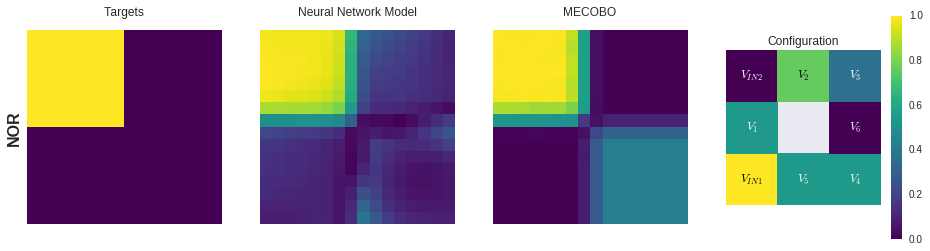

In [86]:
N = 16
for gate in ["AND", "OR", "XOR", "NAND", "NOR"]:
    g = np.load("figures/{}.npz".format(gate))
    X = g["X"]
    T = g["T"]
    sim, ar = run_on_board(X)
    #sim = T
    np.savez("figures/{}_sim.npz".format(gate), X=X, T=T, sim=sim, N=N)
    fig = visualize_config(net, X, T, N, sim=sim, ylabel=gate)
    fig.savefig('figures/{}_sim.pdf'.format(gate), bbox_inches='tight', pad_inches=0)
    